Pre-trained model loaded from my_save_dir/models/701.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
2

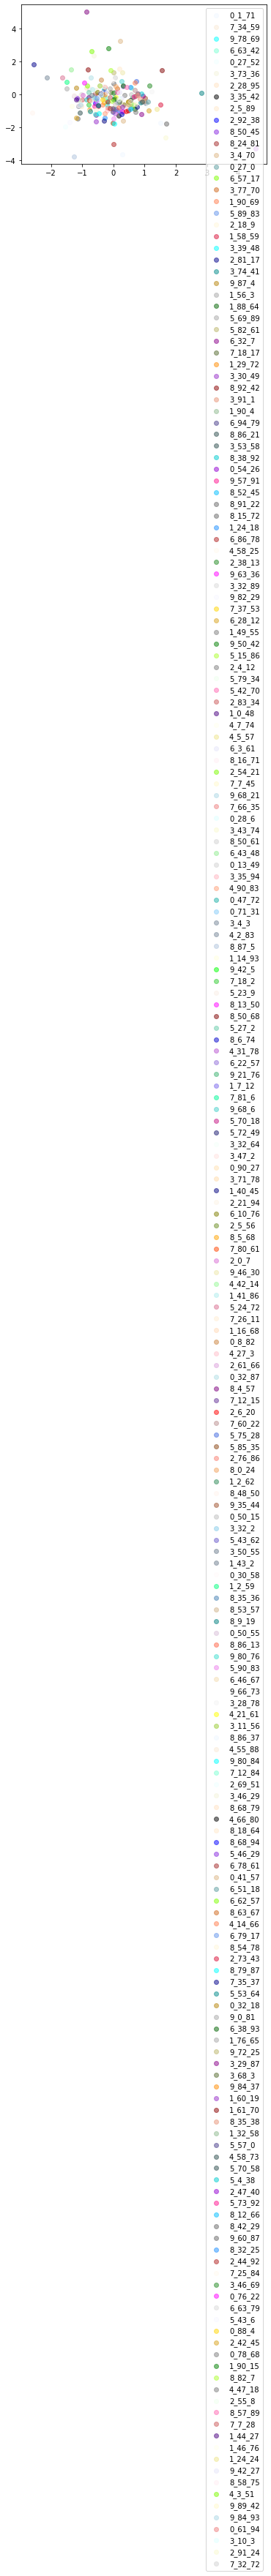

{'tensor': tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 3., 1., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]]), 'binary_label': ['8_13_69', '0_88_25', '7_55_72', '5_54_50']}
{'tensor': tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]]), 'binary_label': ['5_89_90', '3_71_52', '1_62_21', '6_28_37']}
{'tensor': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 6., 0., 0.],
        [0., 0., 4.,  ..., 3., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'binary_label': ['2_94_80', '0_86_39', '5_1_58', '1_37_48']}
{'tensor': tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]]), 'binary_label': ['1_64_90', '7_92_83', '9_15_84', '5_50_36']}
{'tensor': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0

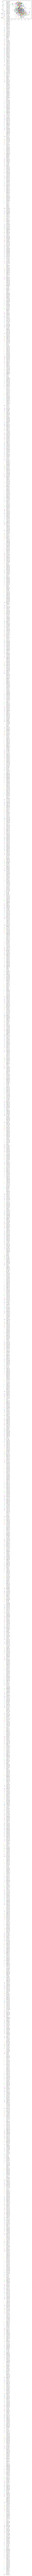

In [1]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

from final_dataloader import RNA_Dataset
from final_dataloader import ImageDataset
from model_from_master import FC_Autoencoder, FC_Classifier, VAE, FC_VAE, Simple_Classifier

import os
import argparse
import numpy as np
import imageio

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors

torch.manual_seed(1)

#============ PARSE ARGUMENTS =============

#parse arguments
options = argparse.ArgumentParser()

# save and directory options
options.add_argument('-sd', '--save-dir', action="store", dest="save_dir", default="my_save_dir/rna")
options.add_argument('--save-freq', action="store", dest="save_freq", default=100, type=int)
options.add_argument('--pretrained-file', action="store", default="my_save_dir/models/701.pth") #last epoch of train_ae.py

# training parameters
options.add_argument('-bs', '--batch-size', action="store", dest="batch_size", default=4, type=int) #32
options.add_argument('-w', '--num-workers', action="store", dest="num_workers", default=10, type=int) 
options.add_argument('-lrAE', '--learning-rate-AE', action="store", dest="learning_rate_AE", default=1e-4, type=float)
options.add_argument('-lrD', '--learning-rate-D', action="store", dest="learning_rate_D", default=1e-4, type=float)
options.add_argument('-se', '--max-epochs', action="store", dest="max_epochs", default=1000, type=int) # 800
options.add_argument('-wd', '--weight-decay', action="store", dest="weight_decay", default=0, type=float)
options.add_argument('--train-imagenet', action="store_true")
options.add_argument('--conditional', action="store_true")
options.add_argument('--conditional-adv', action="store_true")

# hyperparameters
options.add_argument('--alpha', action="store", default=0.1, type=float)
options.add_argument('--beta', action="store", default=1., type=float)
options.add_argument('--lamb', action="store", default=0.00000001, type=float)
options.add_argument('--latent-dims', action="store", default=128, type=int)

# gpu options
options.add_argument('-gpu', '--use-gpu', action="store_false", dest="use_gpu")

args, unknown = options.parse_known_args()

if not torch.cuda.is_available():
    args.use_gpu = False

os.makedirs(args.save_dir, exist_ok=True)

#============= TRAINING INITIALIZATION ==============

# initialize autoencoder
netRNA = FC_VAE(n_input=15814, nz=args.latent_dims)

netImage = VAE(latent_variable_size=args.latent_dims, batchnorm=True)
netImage.load_state_dict(torch.load(args.pretrained_file))
print("Pre-trained model loaded from %s" % args.pretrained_file)


if args.use_gpu:
    netRNA.cuda()
    netImage.cuda()
    

# load data
genomics_dataset = RNA_Dataset(datadir="data_folder/my_data/")
image_dataset = ImageDataset(datadir="data_folder/my_data//", mode='test') #test

image_loader = DataLoader(image_dataset, batch_size=args.batch_size, drop_last=True, shuffle=True)
genomics_loader = DataLoader(genomics_dataset, batch_size=args.batch_size, drop_last=True, shuffle=True)

# setup optimizer
opt_netRNA = optim.Adam(list(netRNA.parameters()), lr=args.learning_rate_AE)
opt_netImage = optim.Adam(list(netImage.parameters()), lr=args.learning_rate_AE)


# loss criteria
criterion_reconstruct = nn.MSELoss()
criterion_classify = nn.CrossEntropyLoss()

# setup logger
with open(os.path.join(args.save_dir, 'log.txt'), 'w') as f:
    print(args, file=f)
    print(netRNA, file=f)
    print(netImage, file=f)
    

# define helper train functions

def compute_KL_loss(mu, logvar):
    if args.lamb>0:
        KLloss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return args.lamb * KLloss
    return 0

def train_autoencoders(rna_inputs, image_inputs, rna_class_labels=None, image_class_labels=None):
   
    netRNA.train()
    if args.train_imagenet:
        netImage.train()
    else:
        netImage.eval()
    
    
    # process input data
    rna_inputs, image_inputs = Variable(rna_inputs), Variable(image_inputs)

    if args.use_gpu:
        rna_inputs, image_inputs = rna_inputs.cuda(), image_inputs.cuda()

    # reset parameter gradients
    netRNA.zero_grad()

    # forward pass
    rna_recon, rna_latents, rna_mu, rna_logvar = netRNA(rna_inputs)
    image_recon, image_latents, image_mu, image_logvar = netImage(image_inputs)
    
    '''
    if args.use_gpu:
        rna_labels, image_labels = rna_labels.cuda(), image_labels.cuda()
    '''    

    # compute losses
    rna_recon_loss = criterion_reconstruct(rna_inputs, rna_recon)
    image_recon_loss = criterion_reconstruct(image_inputs, image_recon)
    kl_loss = compute_KL_loss(rna_mu, rna_logvar) + compute_KL_loss(image_mu, image_logvar)
    loss = args.alpha*(rna_recon_loss + image_recon_loss) + kl_loss

    # backpropagate and update model
    loss.backward()
    opt_netRNA.step()
    

    if args.train_imagenet:
        opt_netImage.step()

    summary_stats = {'rna_recon_loss': rna_recon_loss.item(), 'image_recon_loss': image_recon_loss.item()}

    return summary_stats


def accuracy(output, target):
    pred = output.argmax(dim=1).view(-1)
    correct = pred.eq(target.view(-1)).float().sum().item()
    return correct

def generate_image(epoch):
    img_dir = os.path.join(args.save_dir, "images")
    os.makedirs(img_dir, exist_ok=True)
    netRNA.eval()
    netImage.eval()

    for i in range(5):
        samples = genomics_loader.dataset[np.random.randint(30)]
        rna_inputs = samples['tensor']
        rna_inputs = Variable(rna_inputs.unsqueeze(0))
        samples = image_loader.dataset[np.random.randint(10)]
        image_inputs = samples['image_tensor']
        image_inputs = Variable(image_inputs.unsqueeze(0))
 
        if torch.cuda.is_available():
            rna_inputs = rna_inputs.cuda()
            image_inputs = image_inputs.cuda()
 
        _, rna_latents, _, _ = netRNA(rna_inputs)
        recon_inputs = netImage.decode(rna_latents)
        imageio.imwrite(os.path.join(img_dir, "epoch_%s_trans_%s.jpg" % (epoch, i)), np.uint8(recon_inputs.cpu().data.view(64,64).numpy()*255))
        recon_images, _, _, _ = netImage(image_inputs)
        imageio.imwrite(os.path.join(img_dir, "epoch_%s_recon_%s.jpg" % (epoch, i)), np.uint8(recon_images.cpu().data.view(64,64).numpy()*255))
 
### main training loop
for epoch in range(args.max_epochs):
    print(epoch)

    if epoch % args.save_freq == 0:
        generate_image(epoch)

    
    recon_rna_loss = 0
    recon_image_loss = 0

    n_rna_correct = 0
    n_rna_total = 0
    
    

    for idx, (rna_samples, image_samples) in enumerate(zip(genomics_loader, image_loader)):
        rna_inputs = rna_samples['tensor']
        image_inputs = image_samples['image_tensor']

        
        out = train_autoencoders(rna_inputs, image_inputs)

        recon_rna_loss += out['rna_recon_loss']
        recon_image_loss += out['image_recon_loss']


    with open(os.path.join(args.save_dir, 'log.txt'), 'a') as f:
        print('Epoch: ', epoch, ', rna recon loss: %.8f' % float(recon_rna_loss), ', image recon loss: %.8f' % float(recon_image_loss), file=f)

    # save model
    if epoch % args.save_freq == 0:
        torch.save(netRNA.cpu().state_dict(), os.path.join(args.save_dir,"netRNA_%s.pth" % epoch))
        torch.save(netImage.cpu().state_dict(), os.path.join(args.save_dir,"netImage_%s.pth" % epoch))
        

    if args.use_gpu:
        netRNA.cuda()
        netImage.cuda()

def plot_latent_space_with_labels_image(data_loader, model):
    model = model.cuda()
    '''
    labels = []
    for i, dict in enumerate(data_loader):
        label = dict["label"]
        labels = labels + label
    
    d = {i:[] for i in labels}
    '''
    d = {}
    with torch.no_grad():
        for i, dict in enumerate(data_loader):
            print(dict)
            
            images = dict["image_tensor"]
            labels1 = dict["label"]
            
            embedding = model.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d[name] = embedding[i].to("cpu").numpy()
                
    # print(d)
    colors = list(mcolors.CSS4_COLORS.items())*10
    for i,j in zip(list(d.keys()), range(len(list(d.keys())))):
        print(d[i])
        # d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][0], d[i][1],
            color=colors[j][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()


plot_latent_space_with_labels_image(
    data_loader=image_loader,
    model=netImage.cuda())

plt.legend()
plt.show()

def plot_latent_space_with_labels_rna(data_loader, model):
    model = model.cuda()
    
    d = {}
    with torch.no_grad():
        for i, dict in enumerate(data_loader):
            print(dict)
            
            images = dict["tensor"]
            labels1 = dict["binary_label"]
            
            embedding = model.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d[name] = embedding[i].to("cpu").numpy()
                
    # print(d)
    colors = list(mcolors.CSS4_COLORS.items())*50
    for i,j in zip(list(d.keys()), range(len(list(d.keys())))):
        # d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][0], d[i][1],
            color=colors[j][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

plot_latent_space_with_labels_rna(
    data_loader=genomics_loader,
    model=netRNA.cuda())

plt.legend()
plt.show()

In [2]:
from sklearn.neighbors import NearestNeighbors

# now I want to get both rna latent space and image latent space coordinates
# first check if there are matches in the data used - should be 1000 but i might not be using all

def determine_latent_overlap(data1, data2, model1, model2):

    # model 1 - rna
    model1 = model1.cuda()
    
    d1 = {}
    with torch.no_grad():
        for i, dict in enumerate(data1):
            
            images = dict["tensor"]
            labels1 = dict["binary_label"]
            
            embedding = model1.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d1[name] = embedding[i].to("cpu").numpy()
    
    
    # model 2 - images
    d2 = {}
    with torch.no_grad():
        for i, dict in enumerate(data2):
            
            images = dict["image_tensor"]
            labels1 = dict["label"]
            
            embedding = model2.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d2[name] = embedding[i].to("cpu").numpy()
    
    
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())

    shared = d1_keys.intersection(d2_keys)

    # print(shared)

    # for those in intersection find knn
    # ideally this would include the real labels

    image_latents = list(d2.values())
    image_latents_array = np.stack(image_latents, axis=0)

    for point in shared:

        # d1 is rna latent point from shared, looking at nearest neighbours in image as smaller
        knn_matrix =np.vstack((d1[point], image_latents_array))
        knn = NearestNeighbors(n_neighbors=3)
        knn.fit(knn_matrix)
        distance, neigh_coords = knn.kneighbors([knn_matrix[0]], return_distance=True)
        print(distance, neigh_coords)

        neigh_labels = []
        for index in neigh_coords[0]:
          if index != 0:
              neigh = next(key for key, value in d2.items() if knn_matrix[index] in value)
            #   neigh = list(d2.keys())[list(d2.values()).index(knn_matrix[index])]
              neigh_labels.append(neigh)
              print(point, neigh)



        
    return neigh
    

In [3]:
determine_latent_overlap(genomics_loader, image_loader, netRNA.cuda(), netImage.cuda())

[[ 0.      92.60759 92.64063]] [[ 0 23 51]]
1_2_62 3_32_64
1_2_62 8_68_79
[[ 0.      82.19132 82.22933]] [[  0 101 213]]
8_12_66 9_42_27
8_12_66 2_54_21
[[ 0.      77.79117 78.06625]] [[  0 101 195]]
6_86_78 9_42_27
6_86_78 3_77_70
[[1.9073486e-06 9.3349060e+01 9.3540039e+01]] [[ 0 17 23]]
9_50_42 1_2_62
9_50_42 3_32_64
[[  0.      111.15105 111.3072 ]] [[  0 101  31]]
8_50_61 9_42_27
8_50_61 1_58_59
[[ 0.      97.19648 97.26378]] [[  0  31 195]]
7_37_53 1_58_59
7_37_53 3_77_70
[[  0.      120.80029 121.3668 ]] [[  0 101  31]]
2_55_8 9_42_27
2_55_8 1_58_59
[[2.69739826e-06 1.22087654e+02 1.22472679e+02]] [[  0 101  31]]
8_35_36 9_42_27
8_35_36 1_58_59
[[ 0.      78.4122  78.46224]] [[  0 193  17]]
3_68_3 8_42_29
3_68_3 1_2_62
[[  0.       118.337265 118.77835 ]] [[  0 101  31]]
3_53_58 9_42_27
3_53_58 1_58_59
[[ 0.      70.62432 70.85829]] [[  0 178 174]]
4_58_25 2_42_45
4_58_25 1_16_68
[[  0.      132.37277 132.41122]] [[  0 213 193]]
2_73_43 2_54_21
2_73_43 8_42_29
[[ 0.      83.0804

'1_58_59'

In [4]:
# create boxplot vsualisation

from scipy.spatial import distance
import random
import pandas as pd

def boxplot_vis(data1, data2, model1, model2):

    # shared points in image and sequencing
    # model 1 - rna
    model1 = model1.cuda()
    
    d1 = {}
    with torch.no_grad():
        for i, dict in enumerate(data1):
            
            images = dict["tensor"]
            labels1 = dict["binary_label"]
            
            embedding = model1.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d1[name] = embedding[i].to("cpu").numpy()
    
    
    # model 2 - images
    d2 = {}
    with torch.no_grad():
        for i, dict in enumerate(data2):
            
            images = dict["image_tensor"]
            labels1 = dict["label"]
            
            embedding = model2.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d2[name] = embedding[i].to("cpu").numpy()
    
    
    d1_keys = set(d1.keys())
    d2_keys = set(d2.keys())

    shared = d1_keys.intersection(d2_keys)
    
    dist = {}
    # find distance between shared points - calculate mean
    for name in shared:
        dist[name] = distance.euclidean(d2.get(name), d1.get(name))
    
    dist_rand = {}
    # find distance between imaging and random points
    d1_list = list(d1.items())
    d2_list = list(d2.items())

    for i in range(100):
        d1_rand = list(random.choice(d1_list))
        d2_rand = list(random.choice(d2_list))

        name = d1_rand[0] + "_" + d2_rand[0]

        dist_rand[name] = distance.euclidean(d2.get(d2_rand[0]), d1.get(d1_rand[0]))

    # plot boxplot

    print(list(dist.values()))

    df_bp = pd.DataFrame(list(zip(list(dist.values()), list(dist_rand.values()))), columns = ["matched", "unmatched"])
    
    boxplot = df_bp.boxplot(column=["matched", "unmatched"])


    return boxplot
    


[82.67396545410156, 90.88517761230469, 68.8542251586914, 102.5809097290039, 138.24319458007812, 123.2627944946289, 64.60504150390625, 109.4496078491211, 124.62019348144531, 106.8154067993164, 127.937744140625, 118.58633422851562, 50.61344528198242, 114.75875091552734, 126.73738861083984, 78.31979370117188, 114.05170440673828, 91.54027557373047, 77.41700744628906, 157.78173828125, 109.26000213623047, 32.582794189453125, 121.6093521118164, 75.04216003417969, 189.0160675048828, 95.37256622314453, 103.17588806152344, 118.78983306884766, 84.83808898925781, 120.7383041381836, 107.83020782470703, 123.83993530273438, 125.74708557128906, 165.26556396484375, 48.52286148071289, 76.54597473144531, 67.40325164794922, 63.247108459472656, 83.29686737060547, 102.16576385498047, 85.10417938232422, 84.5810317993164, 78.84261322021484, 177.09034729003906, 89.1570816040039, 69.03504943847656, 94.46992492675781, 91.37440490722656, 105.30305480957031, 72.64602661132812, 100.70531463623047, 102.7869796752929

<AxesSubplot:>

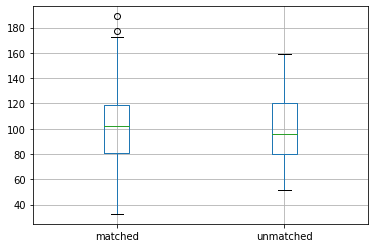

In [5]:
boxplot_vis(genomics_loader, image_loader, netRNA.cuda(), netImage.cuda())

In [8]:
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

# create a pca to check that image and sequences don't form two clusters

def create_pca(data1, data2, model1, model2):
    # table of latent from imaging and from sequencing
    
    # model 1 - rna
    model1 = model1.cuda()
    
    d1 = {}
    with torch.no_grad():
        for i, dict in enumerate(data1):
            
            images = dict["tensor"]
            labels1 = dict["binary_label"]
            
            embedding = model1.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d1[name] = embedding[i].to("cpu").numpy()
    
    
    # model 2 - images
    d2 = {}
    with torch.no_grad():
        for i, dict in enumerate(data2):
            
            images = dict["image_tensor"]
            labels1 = dict["label"]
            
            embedding = model2.get_latent_var(images.cuda())

            for i, name in zip(range(len(labels1)), labels1):
                    d2[name] = embedding[i].to("cpu").numpy()

    # be able to reference which come from imaging and which from sequencing

    im = pd.DataFrame(d2).T
    im["target"] = "image"

    seq = pd.DataFrame(d1).T
    seq["target"] = "seq"

    merged = pd.concat([im, seq], ignore_index=True)
    
    # color code in a pca model

    print(merged.iloc[:, :-1].values)

    pca = PCA(n_components=2)
    pC = pca.fit_transform(merged.iloc[:, :-1].values)
    pDF = pd.DataFrame(data=pC, columns= ["PC1", "PC2"])
    DF = pd.concat([pDF, merged["target"]], axis=1, ignore_index=True)
    DF.columns = ["PC1", "PC2", "target"]


    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    targets = ["image", "seq"]
    colors = ["r", "g"]
    for target, color in zip(targets, colors):
        indicesToKeep = DF["target"] == target
        ax.scatter(DF.loc[indicesToKeep, "PC1"],
                    DF.loc[indicesToKeep, "PC2"],
                    c = color,
                    s=5 )
    ax.legend(targets)
    ax.grid()
    

In [9]:
create_pca(genomics_loader, image_loader, netRNA.cuda(), netImage.cuda())

[[  0.8773295   -1.0049112   -0.25985003 ...   0.39409658  -0.59460723
   -0.03015796]
 [ -0.19858533  -0.3344993   -1.2823627  ...   0.10180813  -1.5970838
    0.6789278 ]
 [  1.2187246   -2.618034    -0.5067329  ...  -0.3150205    0.01508388
    0.47219318]
 ...
 [  3.5086353   -9.486002    -0.81077033 ... -10.651395    12.0767
   -2.2053742 ]
 [  2.3247464   -3.4116716  -10.1317835  ...  -1.9299834    0.7178098
   -5.2084656 ]
 [  3.501523    -5.162095    -3.9015574  ... -12.44318      8.674856
   -3.0651462 ]]


ValueError: array must not contain infs or NaNs